In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'DKK=X'
numbers_in_currency = 'USD'
share_name = 'MAERSK-B.CO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,12169,0,12169,1495,5163,6928,1305,14340,0,...,0,0,2690,11880,11609,29428,2722,-2698,21.98,2014-11-04
1,2014-12-31,11715,0,11715,189,3507,4077,1139,16225,0,...,0,0,1412,9602,10913,26619,2416,-1911,21.98,2015-02-09
2,2015-03-31,10547,0,10547,1572,3078,11036,1034,16103,0,...,0,0,1336,15627,10369,32053,1950,-1985,21.55,2015-05-05
3,2015-06-30,10526,0,10526,1086,1780,6413,977,10608,0,...,0,0,1083,9161,10573,25779,1777,-1893,21.55,2015-08-04
4,2015-09-30,10110,0,10110,778,3233,6069,882,11106,0,...,0,0,1138,8918,11050,26042,2194,-1590,21.55,2015-11-04


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)

## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-06-30,2023-08-04,17.57,88859.896382,0.0,88859.896382,10173.596082,71310.956266,133939.805317,10146.229314,...,571281.286407,0.0,0.0,20737.168612,85185.907749,25184.268446,192716.781743,18972.012062,-5049.168735,6.841692
36,2023-09-30,2023-11-04,17.57,83060.442629,0.0,83060.442629,3793.839988,52250.900920,153910.746812,12114.265233,...,571534.461320,0.0,0.0,20338.817265,87785.622397,27597.789083,195752.556067,9477.751884,-5608.582943,6.848087
37,2023-12-31,2024-02-09,17.57,81406.557563,0.0,81406.557563,-3161.688974,46461.574161,144723.539392,11495.790174,...,569242.685963,0.0,0.0,19739.755505,85913.351057,28905.880119,194624.143666,832.023414,-8673.844094,6.933528
38,2024-03-31,2024-04-29,17.57,84800.819462,0.0,84800.819462,1427.646333,50551.034831,136546.135360,11283.896981,...,560062.911085,0.0,0.0,18881.995495,86544.195273,35663.703596,193727.489220,7515.734303,-4845.761112,6.863684
39,2024-06-30,2024-08-05,15.83,88467.927225,0.0,88467.927225,5770.400390,55799.009772,135448.546004,11360.692244,...,559340.911734,0.0,0.0,21301.297958,84055.268103,33867.331940,191323.755541,11263.710725,-6262.235237,6.927251


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-11-10,6049.936035,2014-09-30,68366.586578,0.0,11006.403466,21.98,0.0,0.0,29006.219615,...,0.594035,0.405965,0.0,0.0,0.0,0.0,1.0,0.122853,0.0,0.0
1,2014-11-17,6152.146973,2014-09-30,68366.586578,0.0,11006.403466,21.98,0.0,0.0,29006.219615,...,0.594035,0.405965,0.0,0.0,0.0,0.0,1.0,0.122853,0.0,0.0
2,2014-11-24,6074.271484,2014-09-30,68366.586578,0.0,11006.403466,21.98,0.0,0.0,29006.219615,...,0.594035,0.405965,0.0,0.0,0.0,0.0,1.0,0.122853,0.0,0.0
3,2014-12-01,5864.982422,2014-09-30,68366.586578,0.0,11006.403466,21.98,0.0,0.0,29006.219615,...,0.594035,0.405965,0.0,0.0,0.0,0.0,1.0,0.122853,0.0,0.0
4,2014-12-08,5538.878906,2014-09-30,68366.586578,0.0,11006.403466,21.98,0.0,0.0,29006.219615,...,0.594035,0.405965,0.0,0.0,0.0,0.0,1.0,0.122853,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-11-10,6049.936035,2014-09-30,68366.586578,0.0,11006.403466,21.98,0.0,0.0,29006.219615,...,0.0,1.0,0.122853,0.0,0.0,inf,0.549674,inf,inf,inf
1,2014-11-17,6152.146973,2014-09-30,68366.586578,0.0,11006.403466,21.98,0.0,0.0,29006.219615,...,0.0,1.0,0.122853,0.0,0.0,inf,0.558961,inf,inf,inf
2,2014-11-24,6074.271484,2014-09-30,68366.586578,0.0,11006.403466,21.98,0.0,0.0,29006.219615,...,0.0,1.0,0.122853,0.0,0.0,inf,0.551885,inf,inf,inf
3,2014-12-01,5864.982422,2014-09-30,68366.586578,0.0,11006.403466,21.98,0.0,0.0,29006.219615,...,0.0,1.0,0.122853,0.0,0.0,inf,0.532870,inf,inf,inf
4,2014-12-08,5538.878906,2014-09-30,68366.586578,0.0,11006.403466,21.98,0.0,0.0,29006.219615,...,0.0,1.0,0.122853,0.0,0.0,inf,0.503241,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

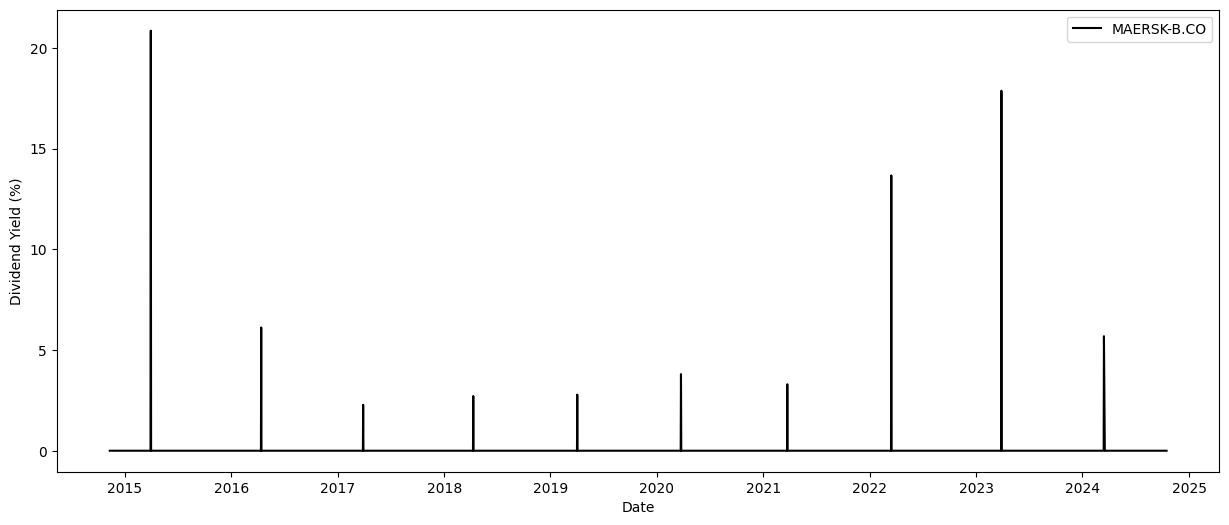

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.263183
share_price      1.000000
Name: share_price, dtype: float64


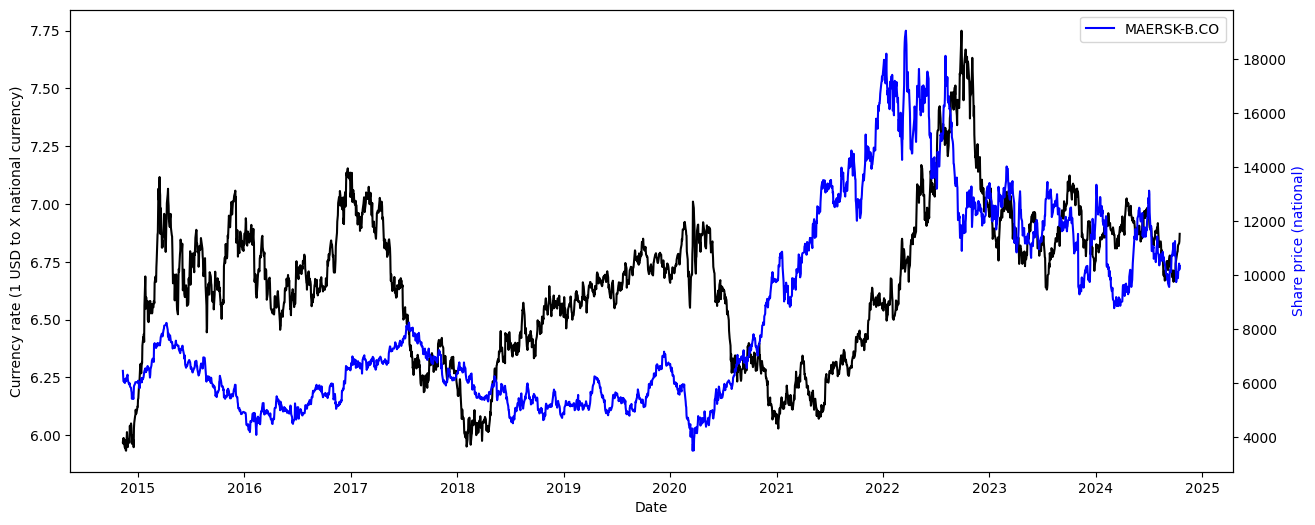

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

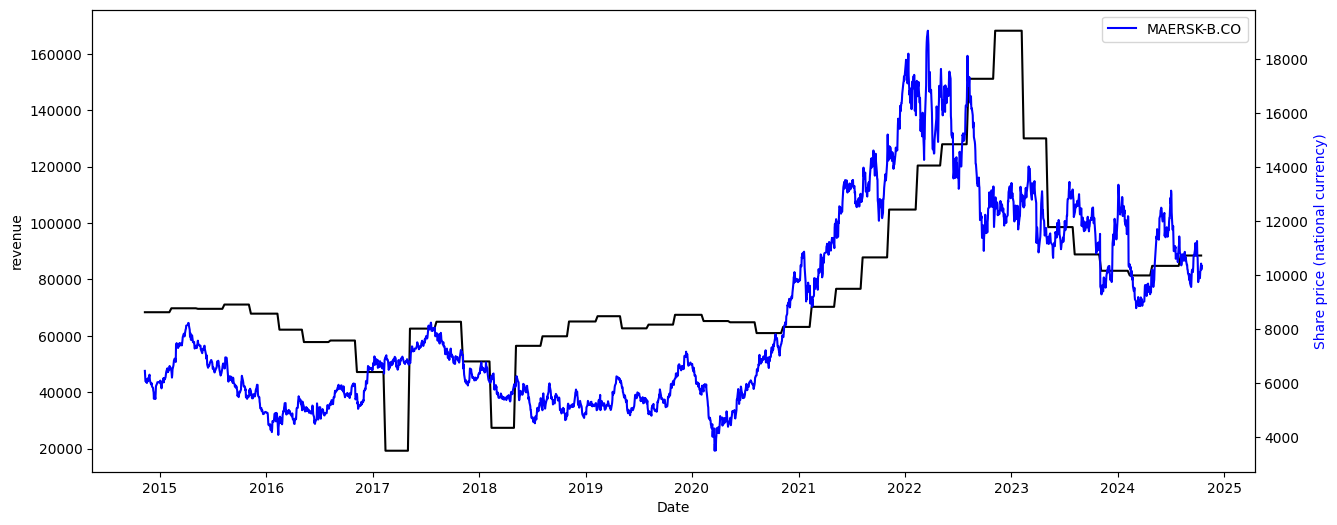

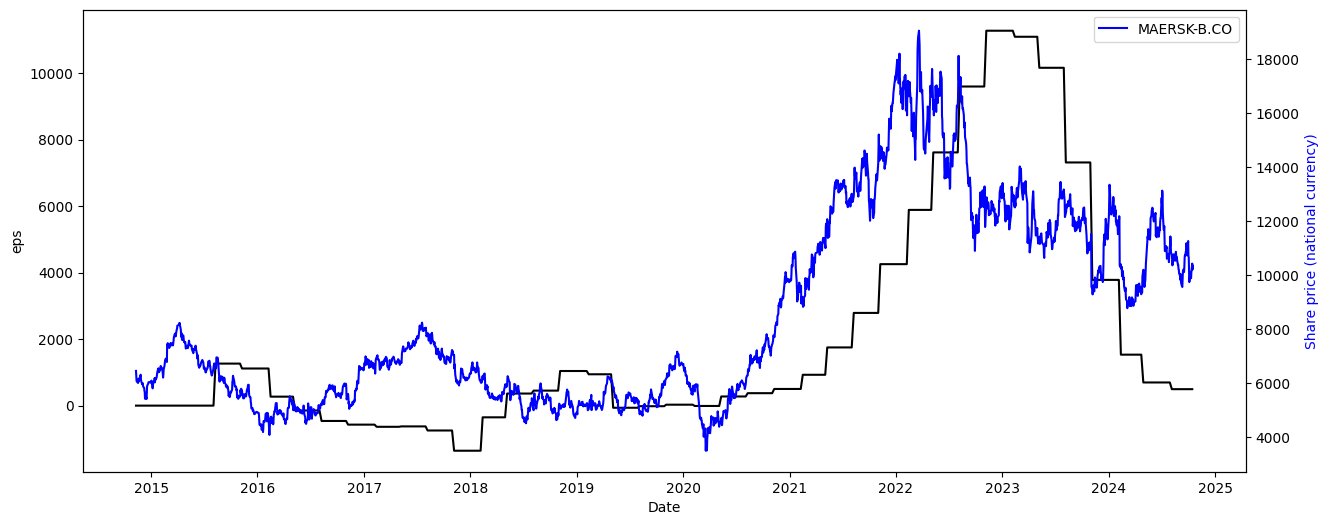

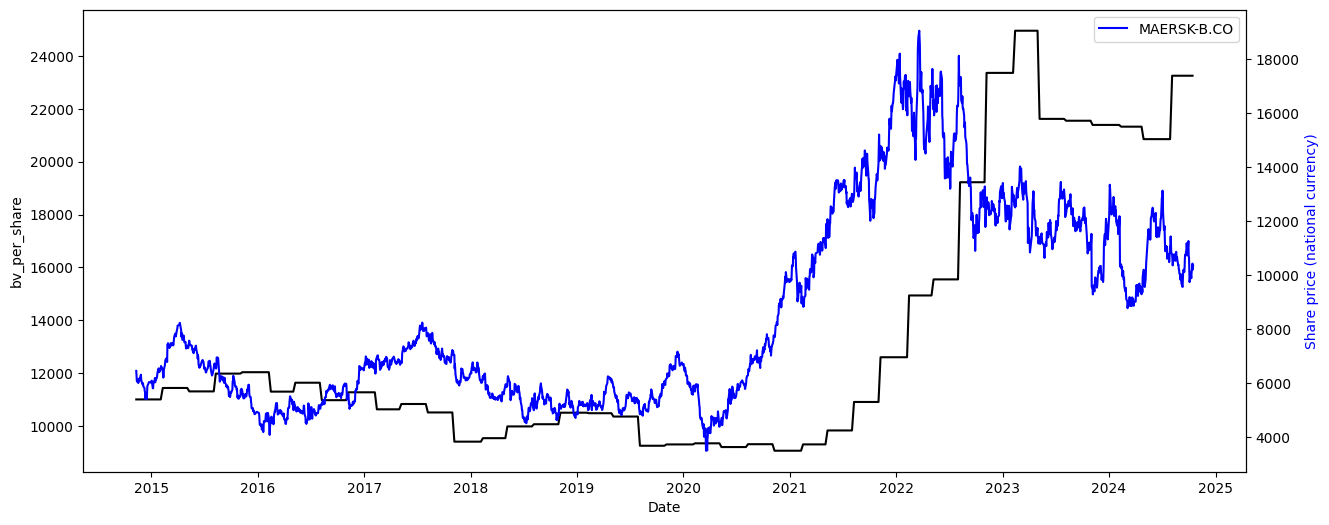

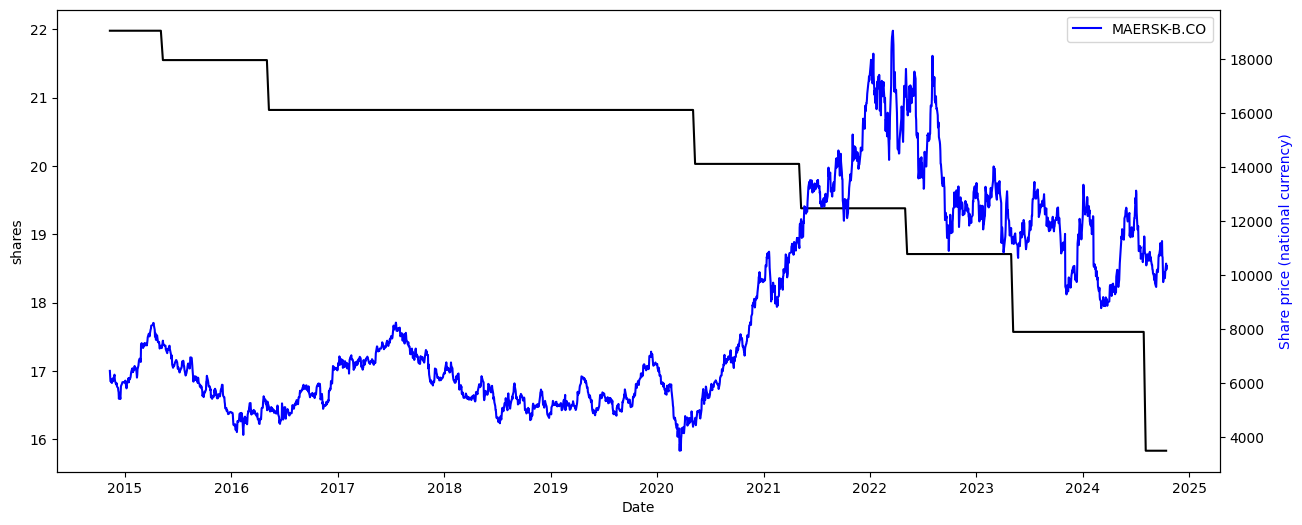

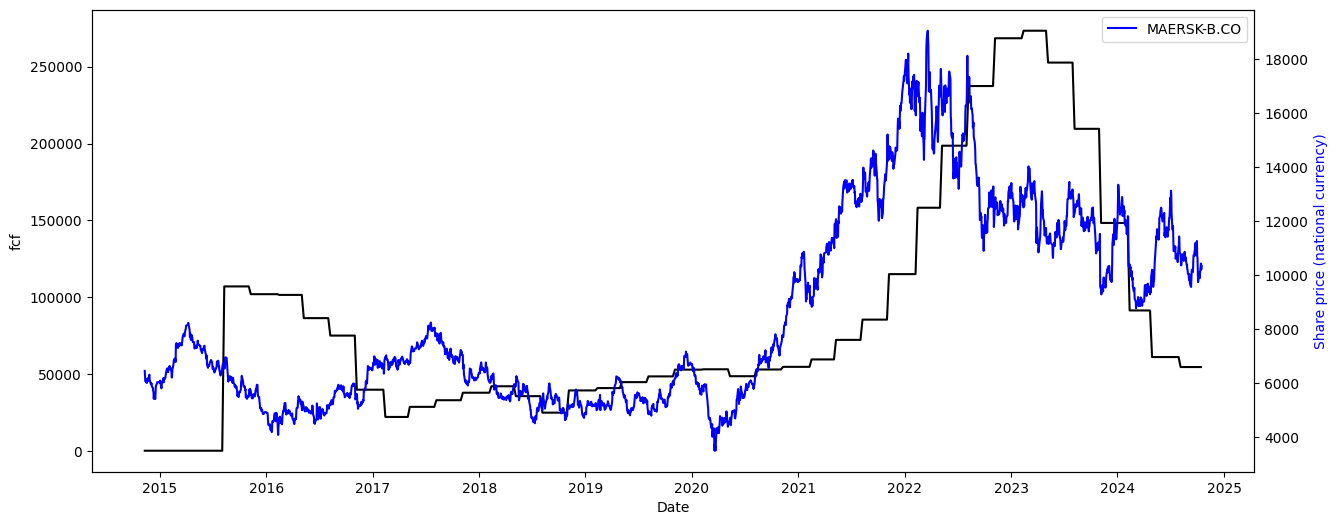

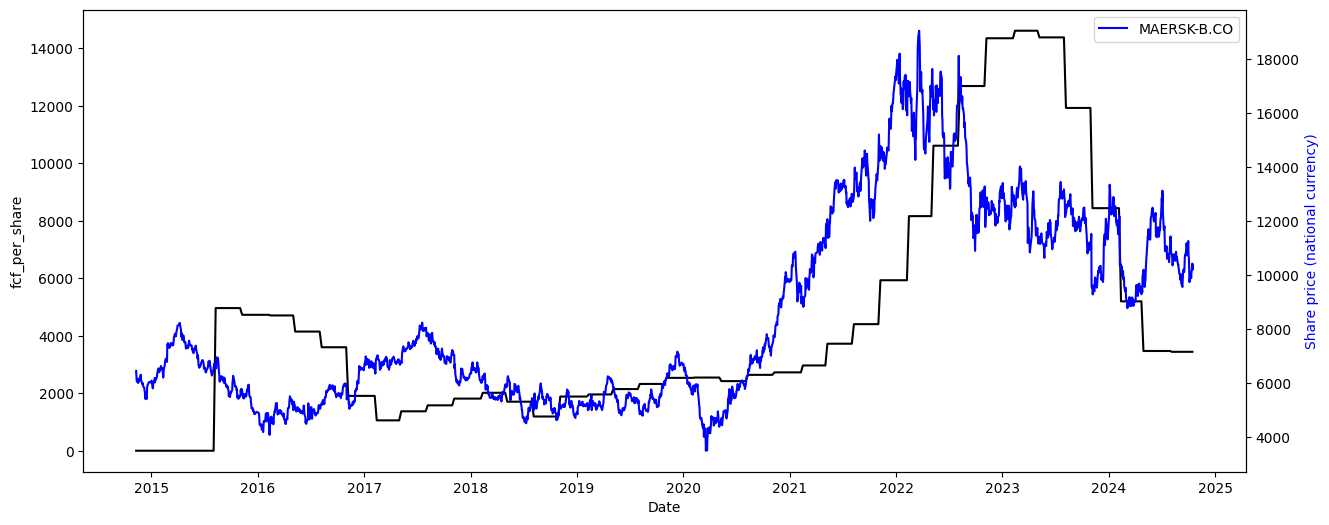

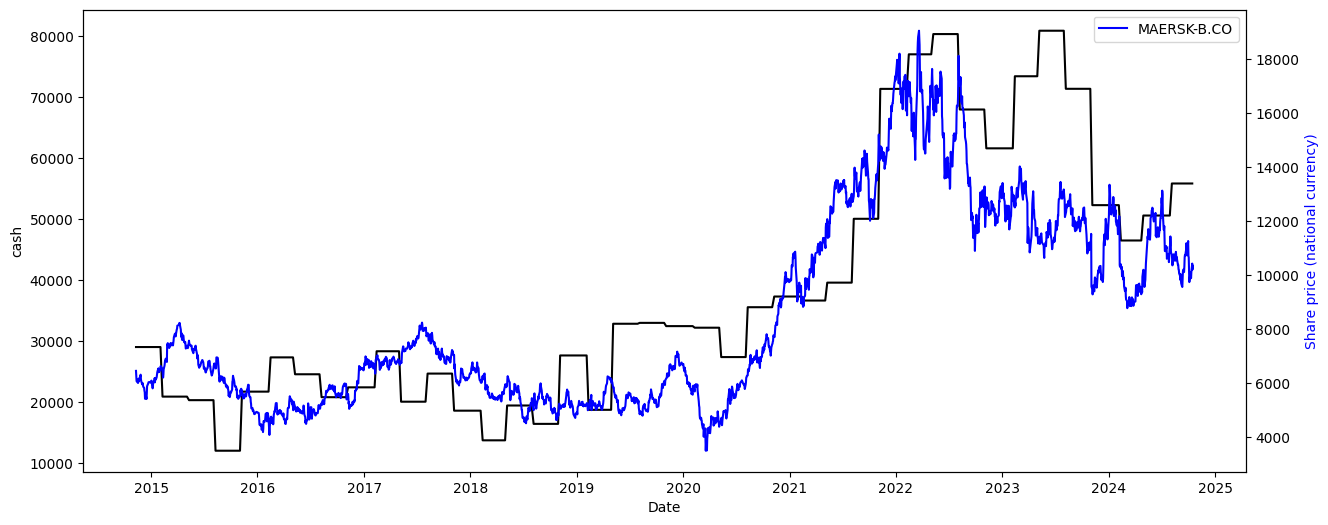

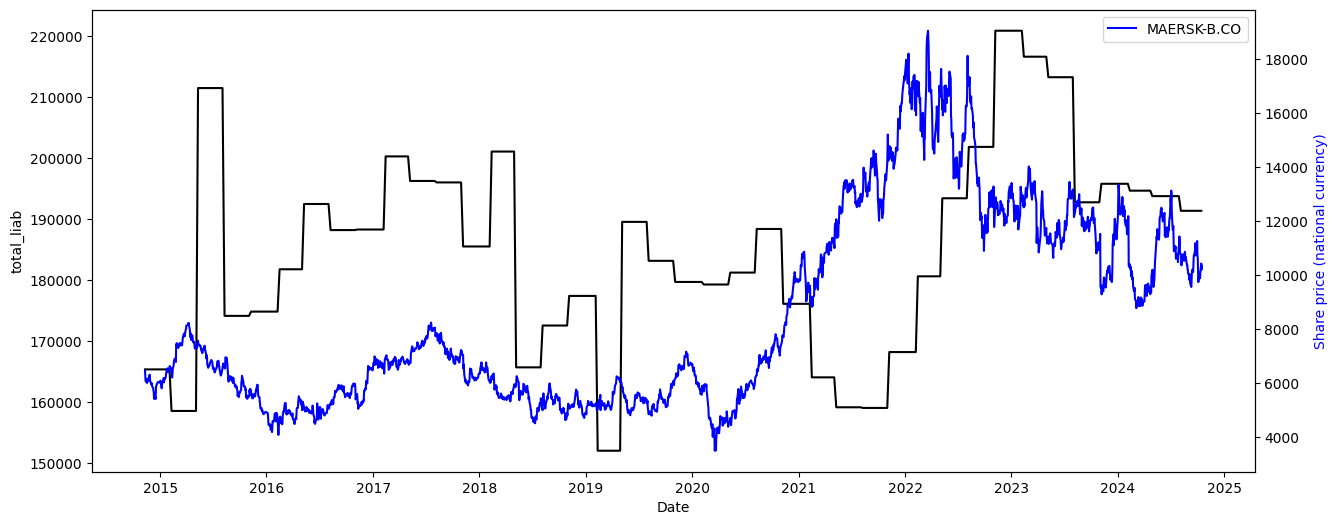

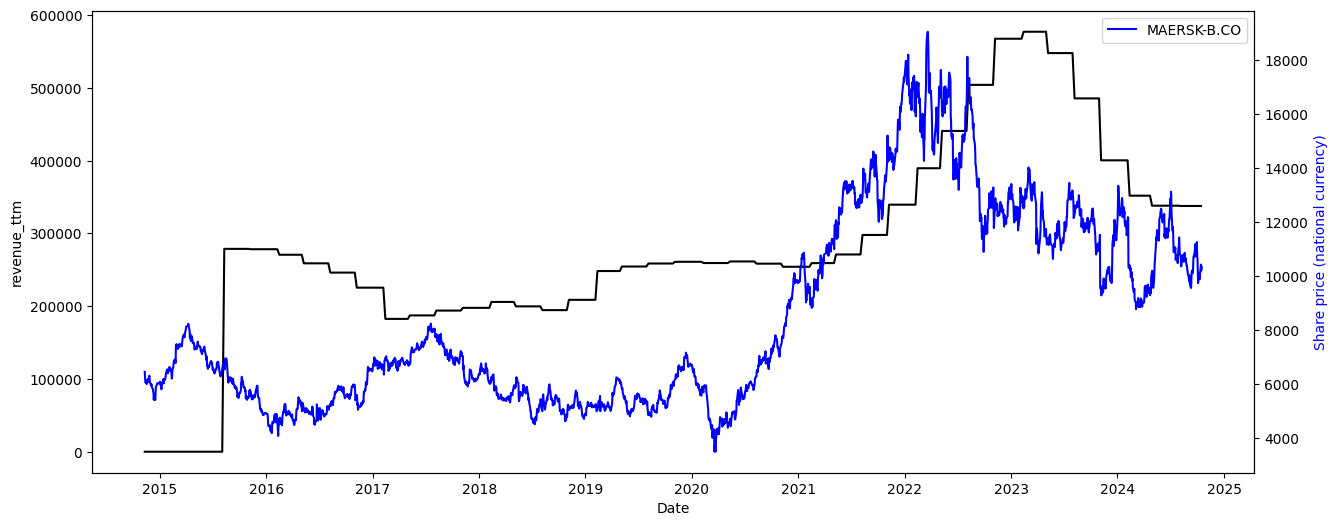

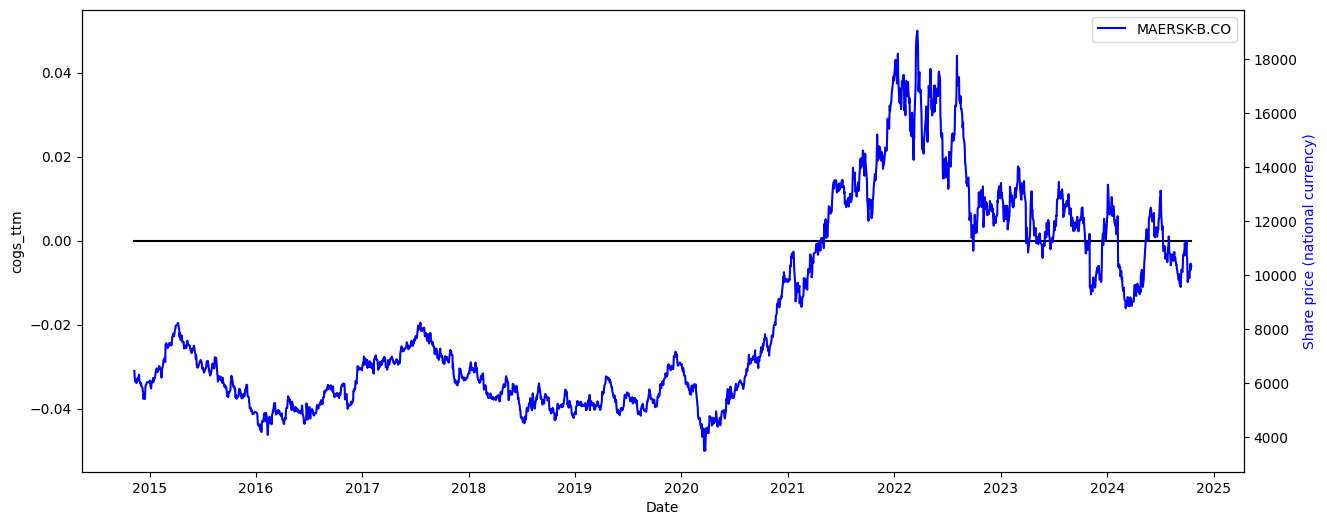

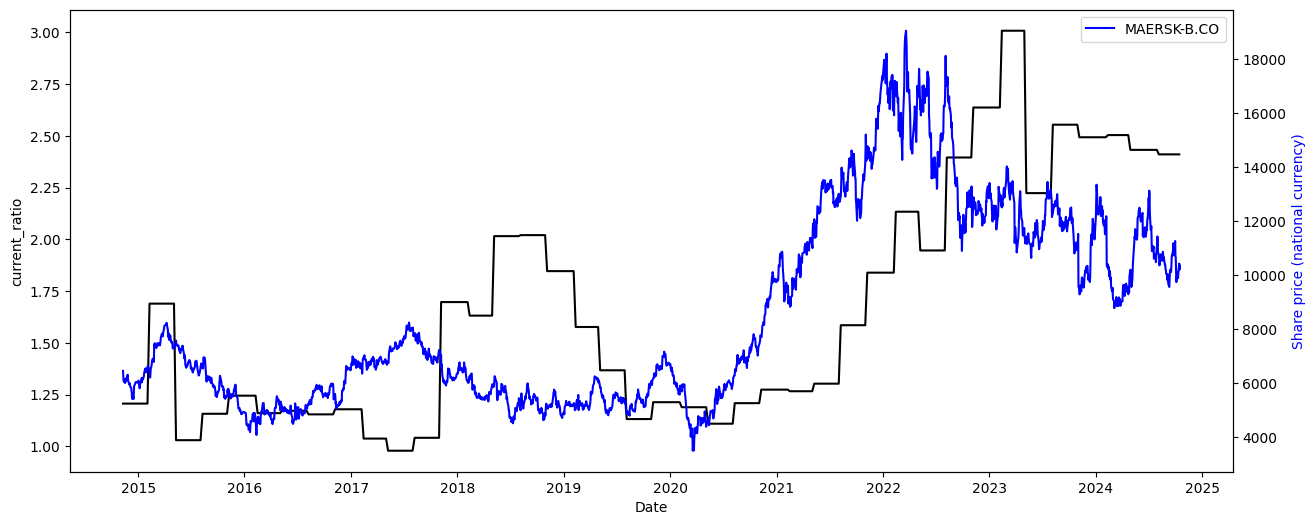

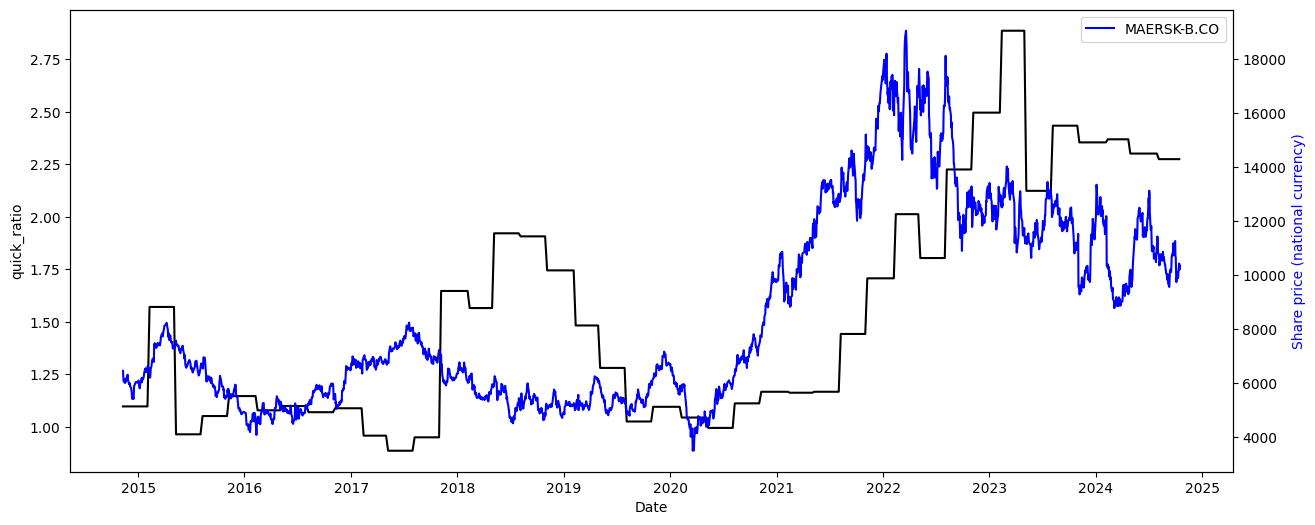

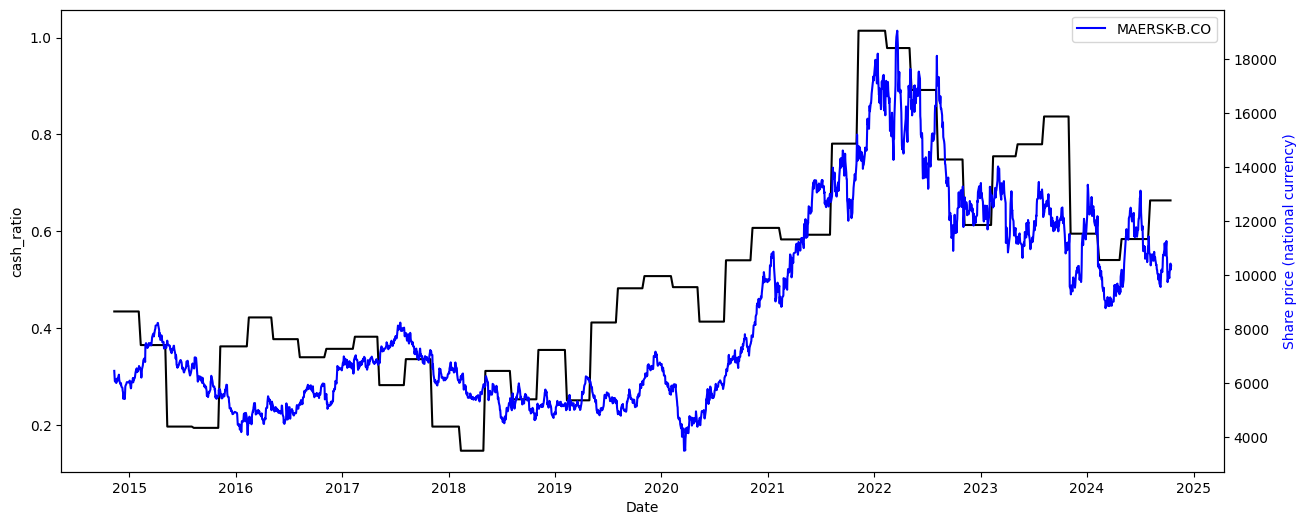

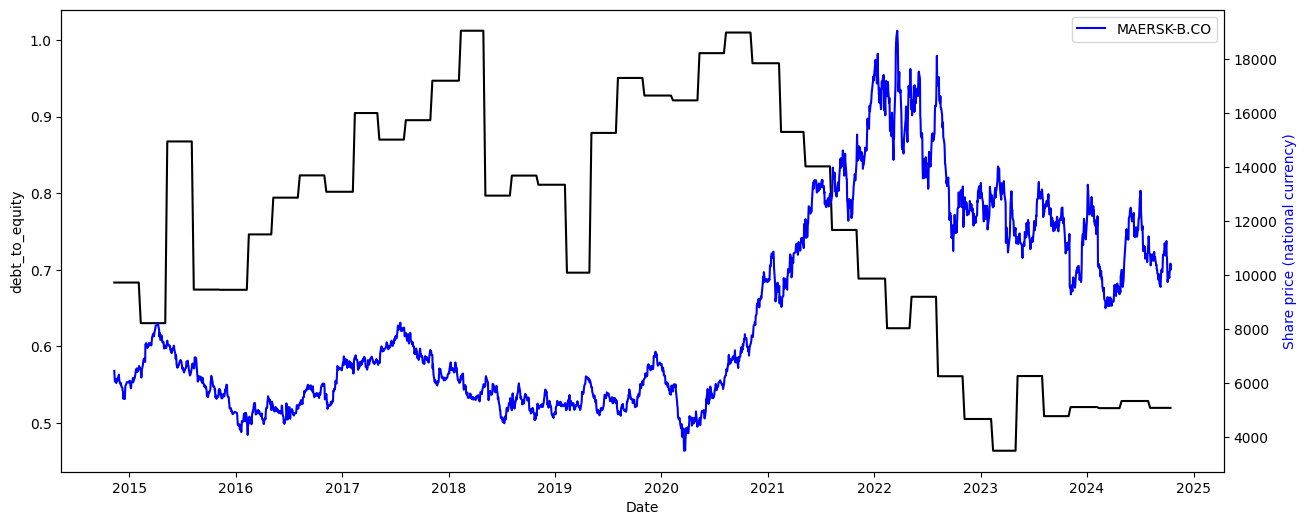

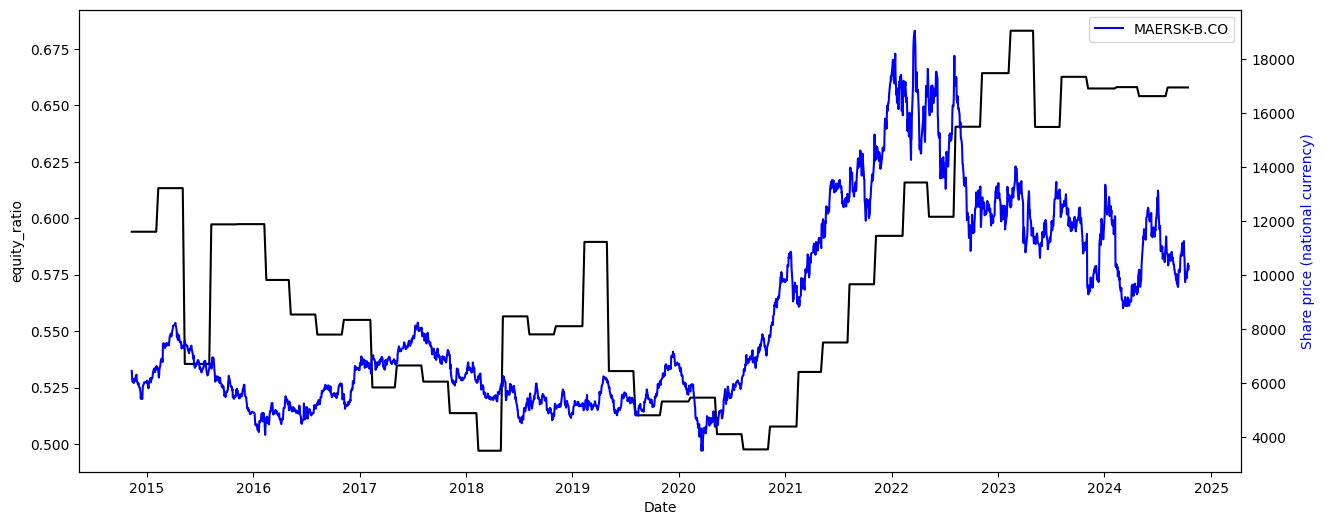

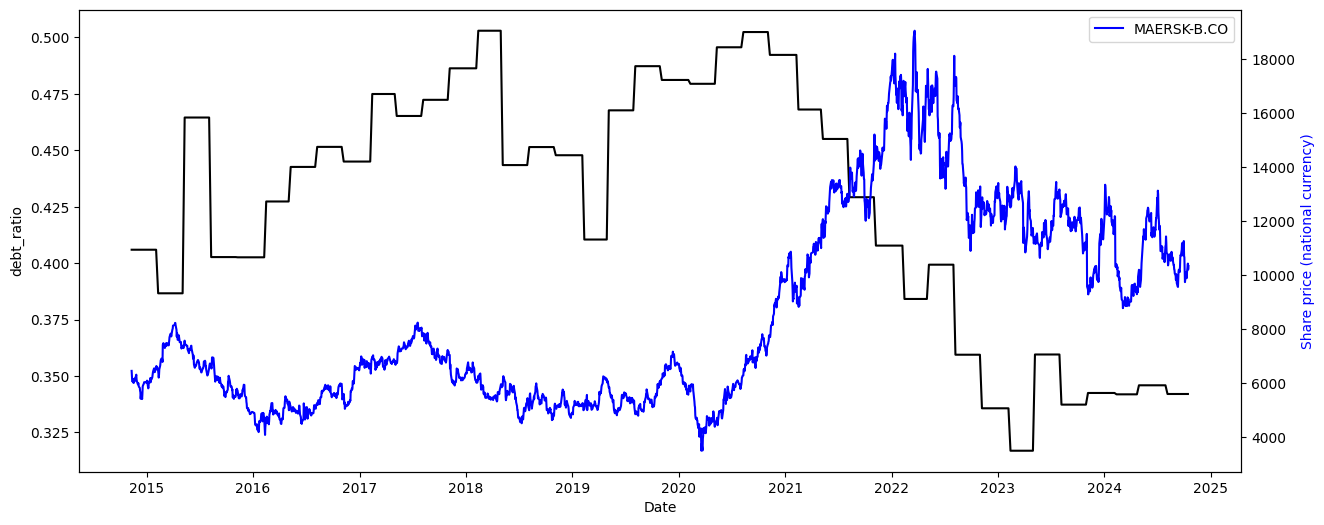

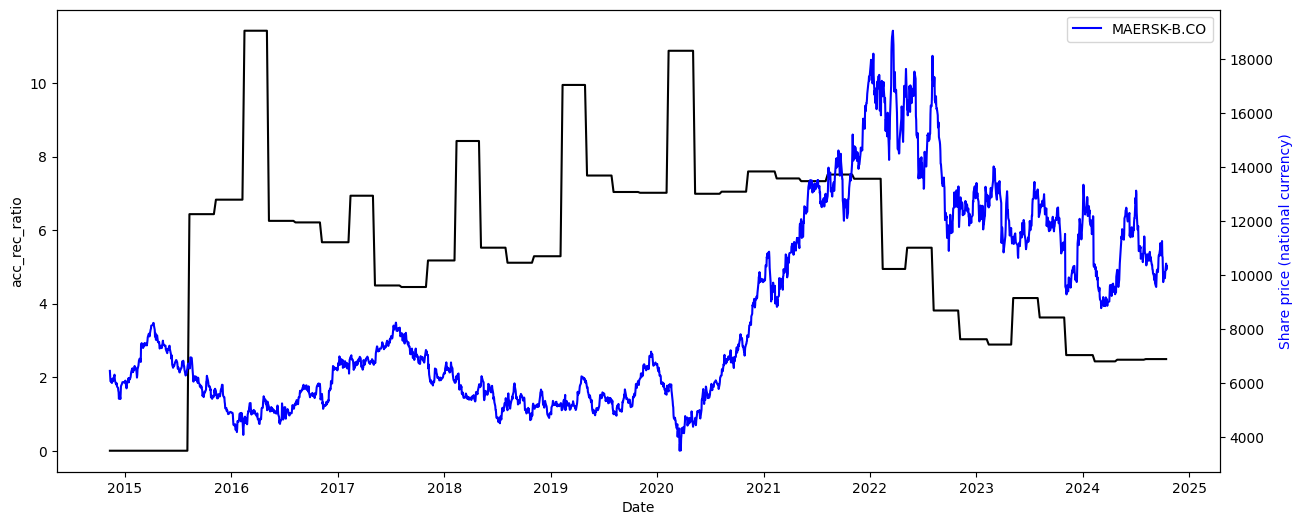

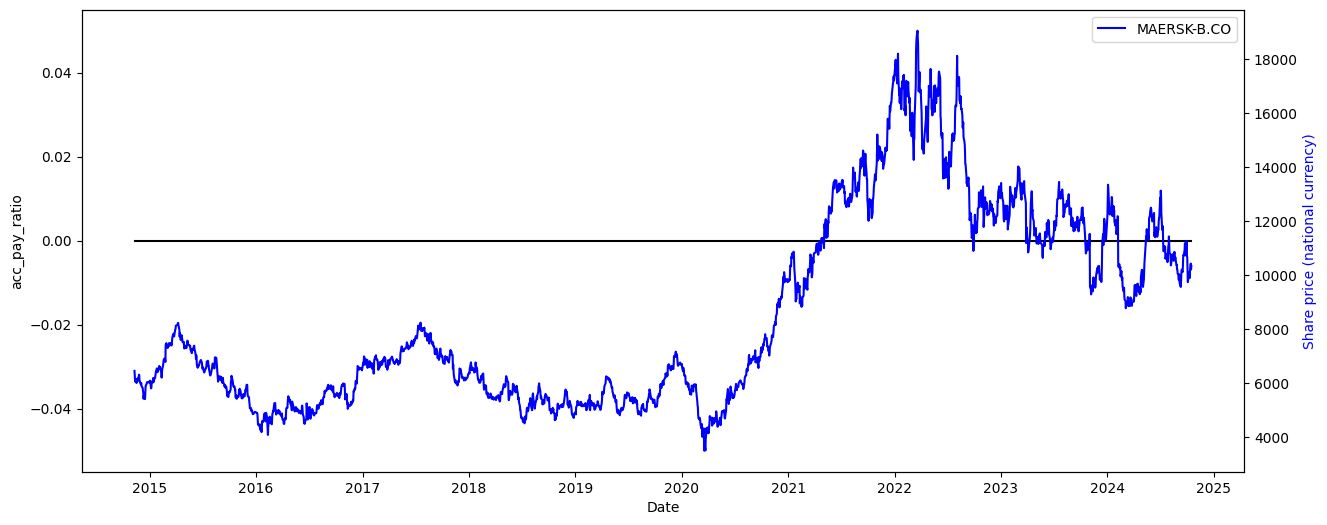

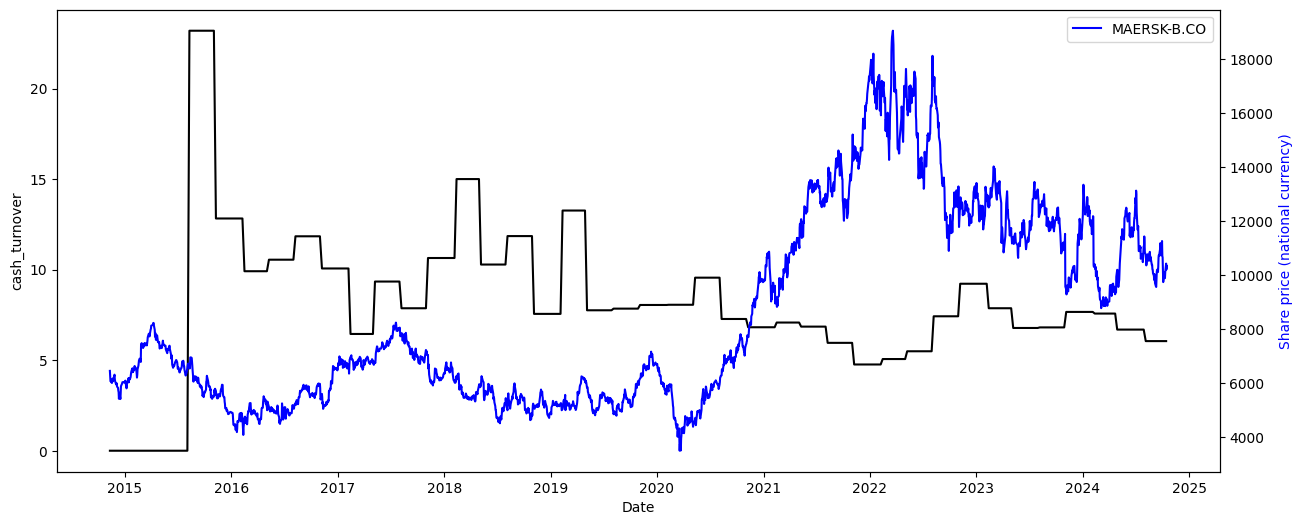

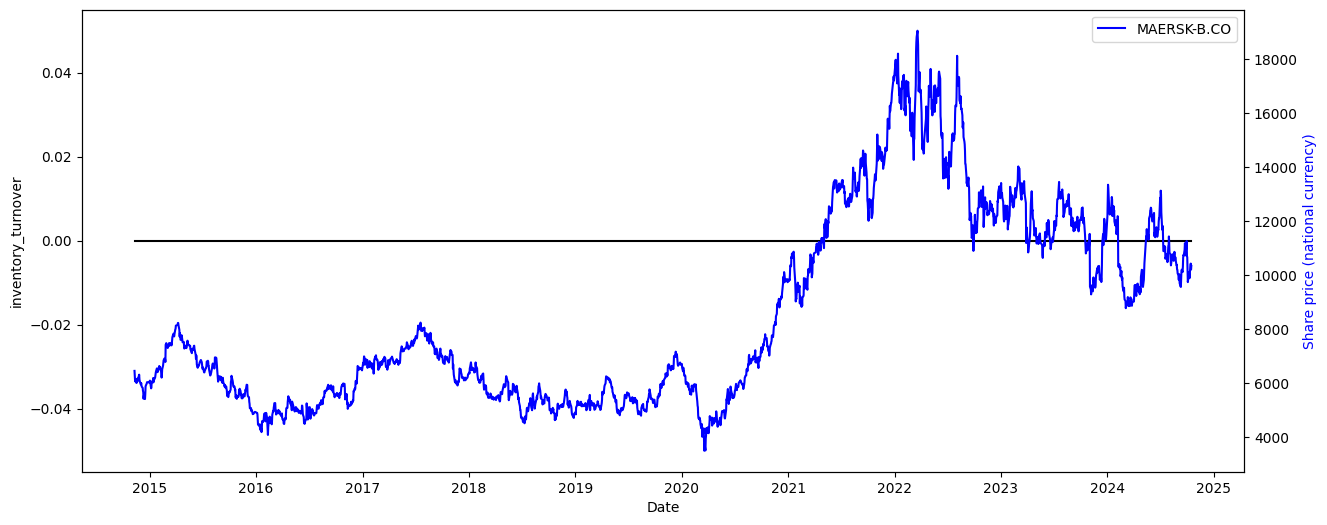

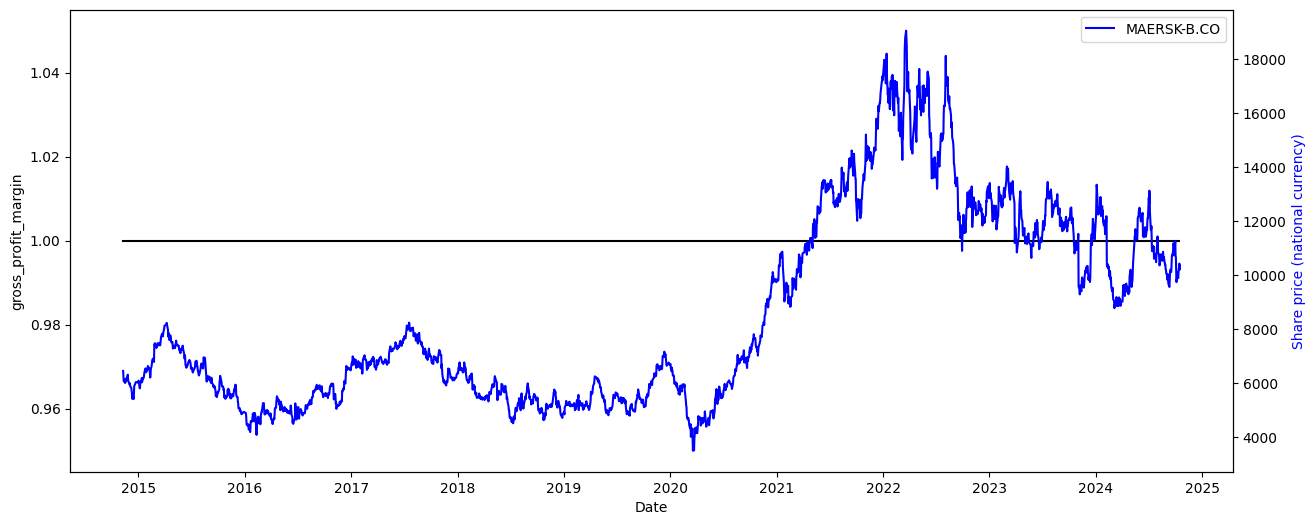

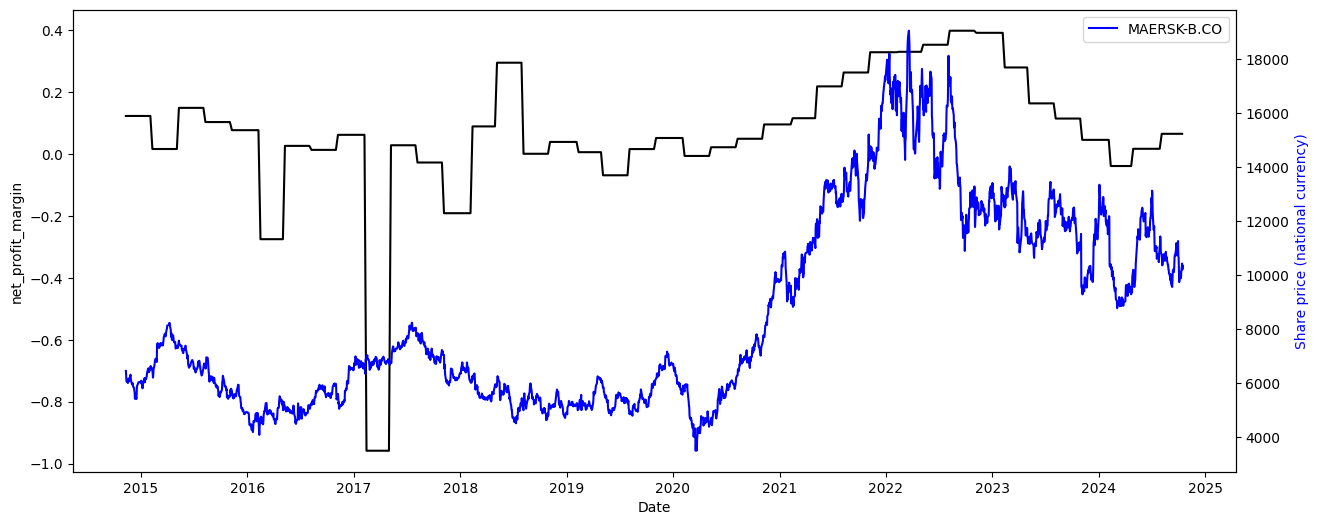

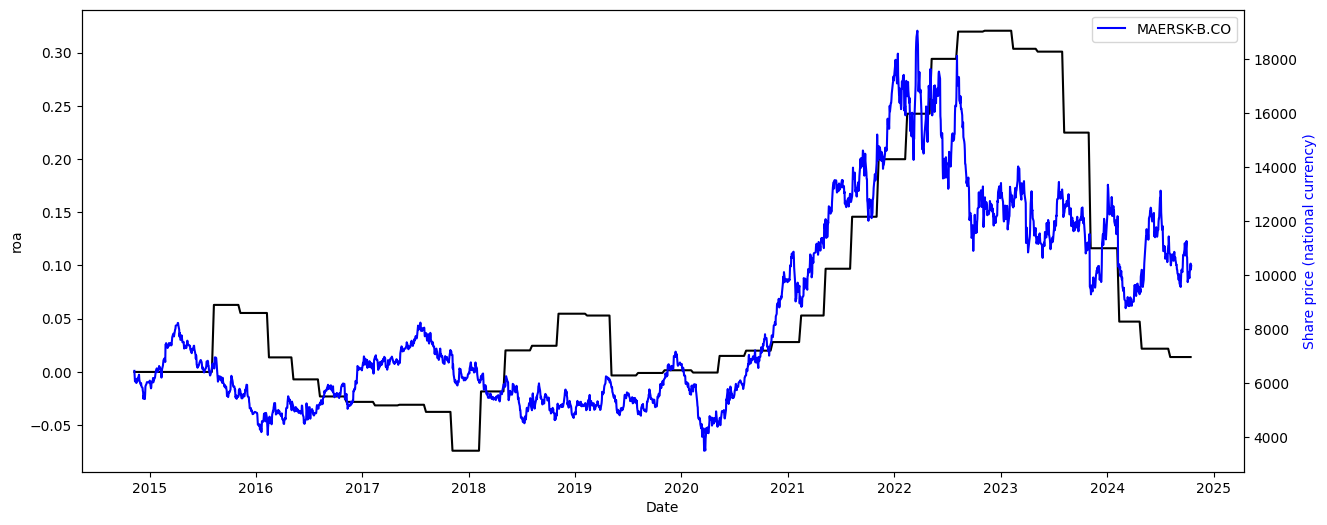

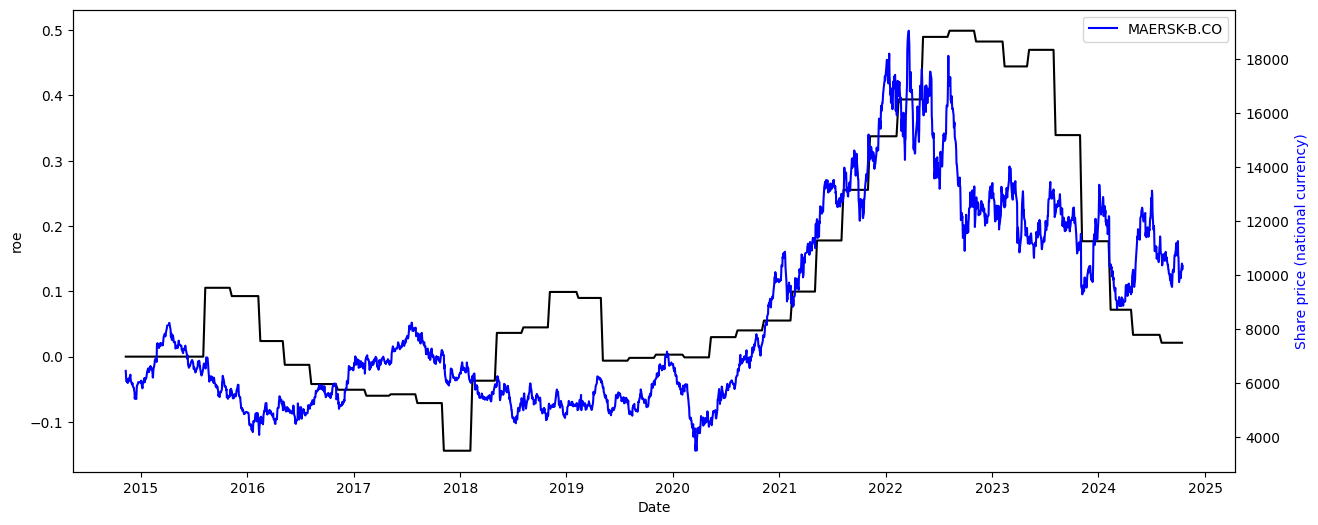

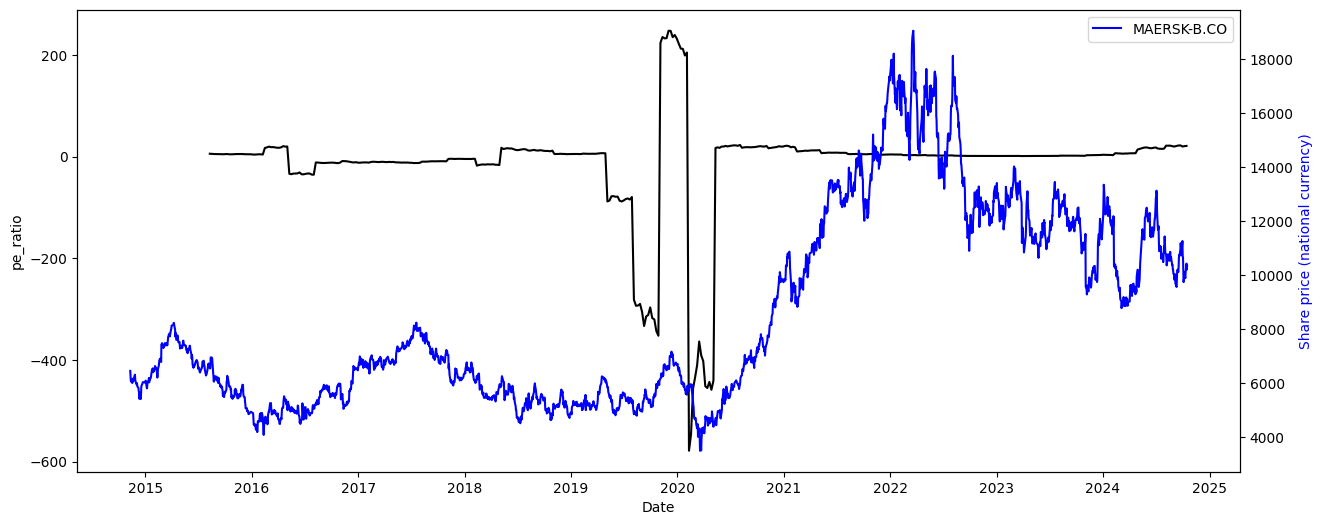

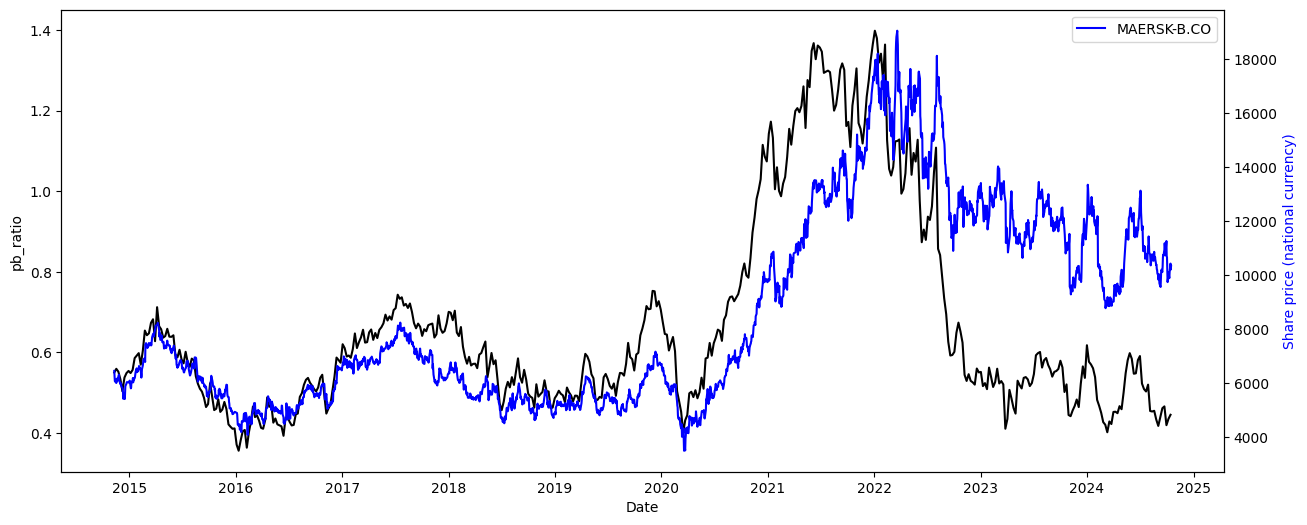

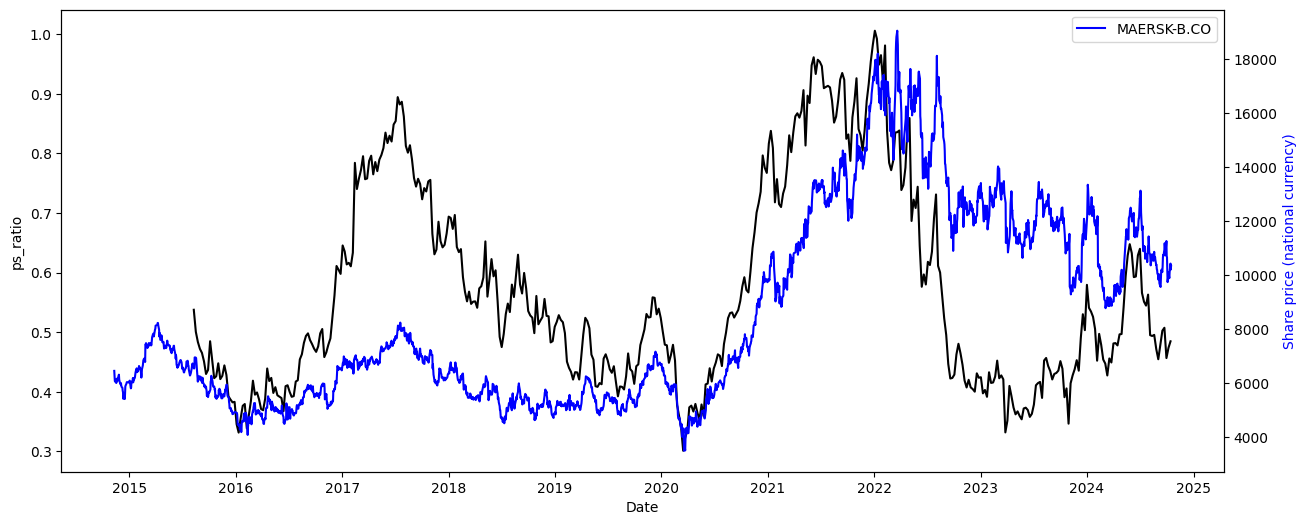

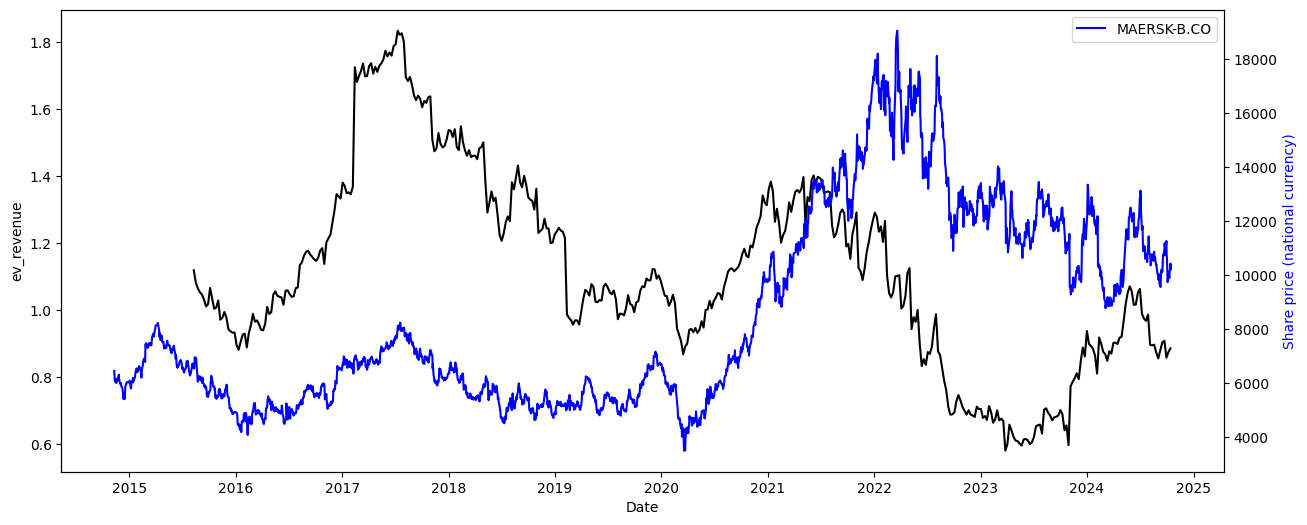

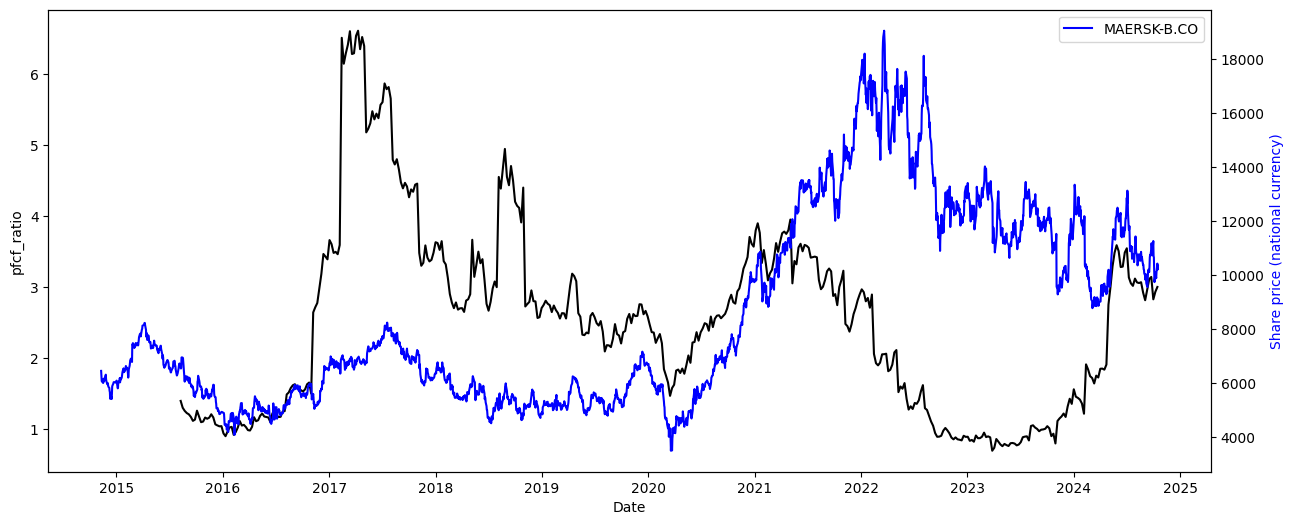

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

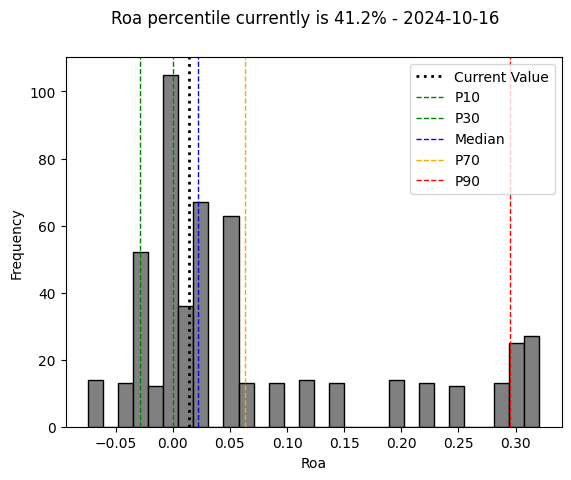

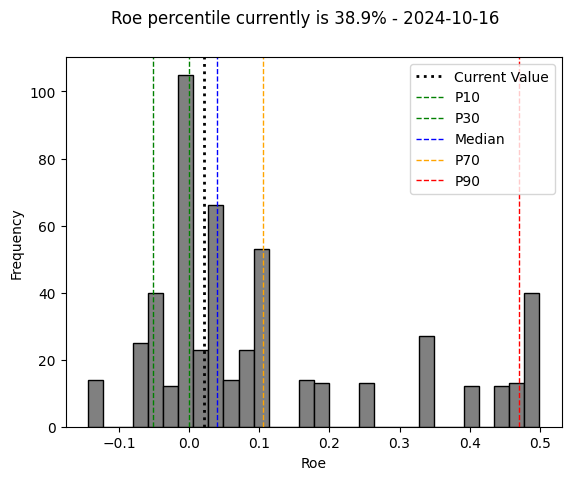

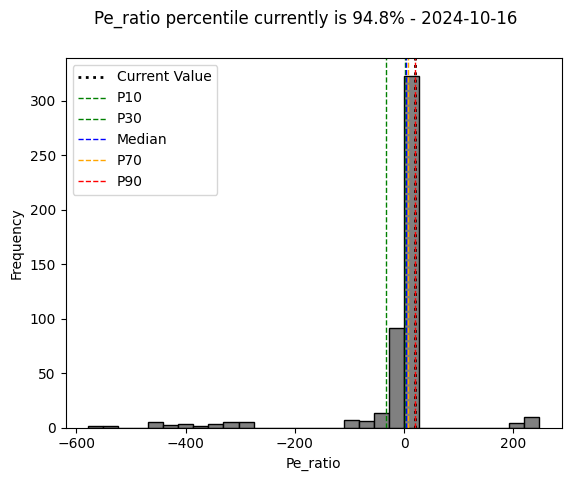

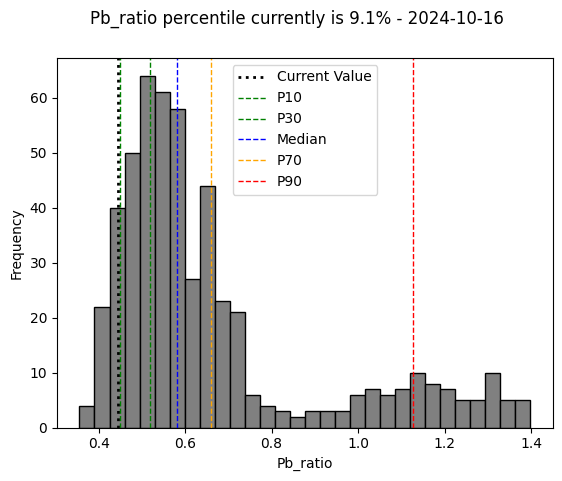

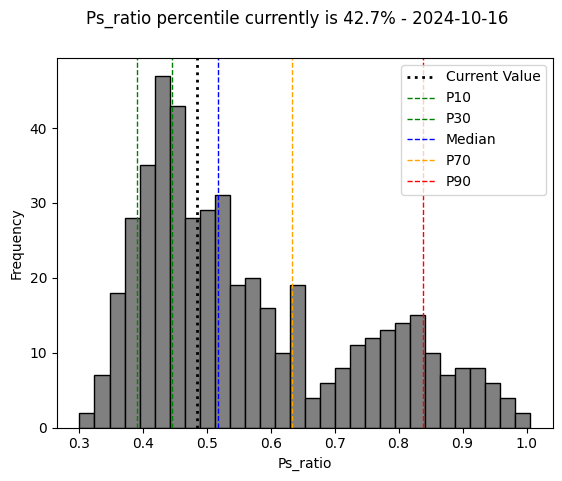

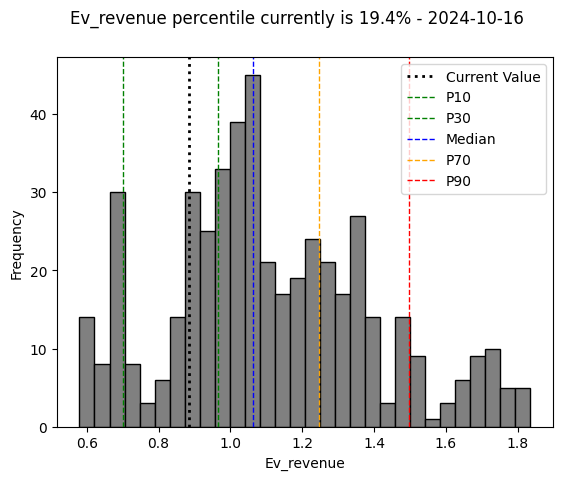

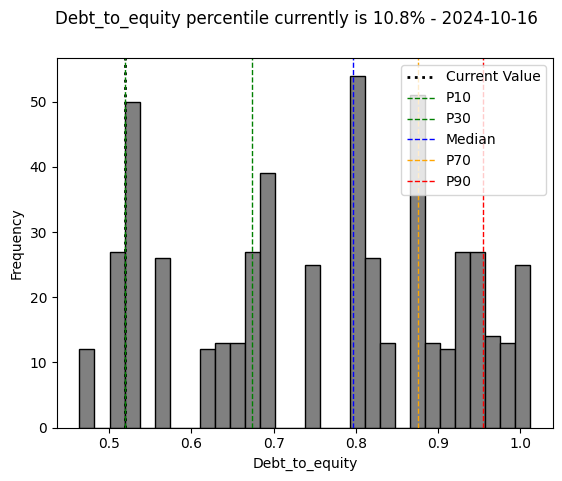

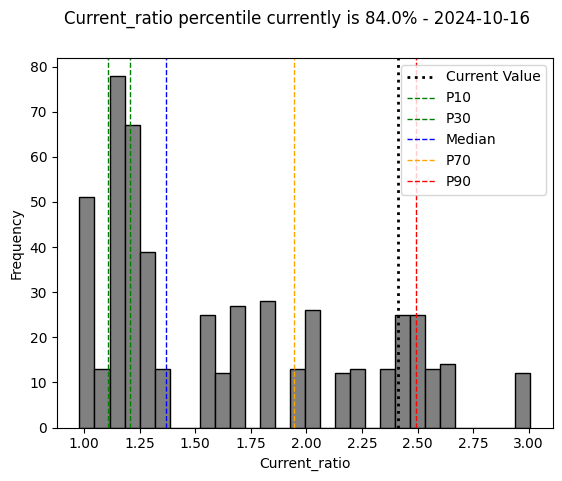

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.997368,0.124025,0.255389,-0.048885,-0.643241,-0.663898,0.681703
roe,0.997368,1.000000,0.127654,0.298133,-0.017350,-0.631324,-0.647067,0.657635
pe_ratio,0.124025,0.127654,1.000000,0.144843,0.200158,0.069743,-0.180947,0.170222
pb_ratio,0.255389,0.298133,0.144843,1.000000,0.854756,0.317362,0.178228,-0.107554
ps_ratio,-0.048885,-0.017350,0.200158,0.854756,1.000000,0.687052,0.250965,-0.207086
ev_revenue,-0.643241,-0.631324,0.069743,0.317362,0.687052,1.000000,0.681315,-0.589551
debt_to_equity,-0.663898,-0.647067,-0.180947,0.178228,0.250965,0.681315,1.000000,-0.791665
current_ratio,0.681703,0.657635,0.170222,-0.107554,-0.207086,-0.589551,-0.791665,1.000000


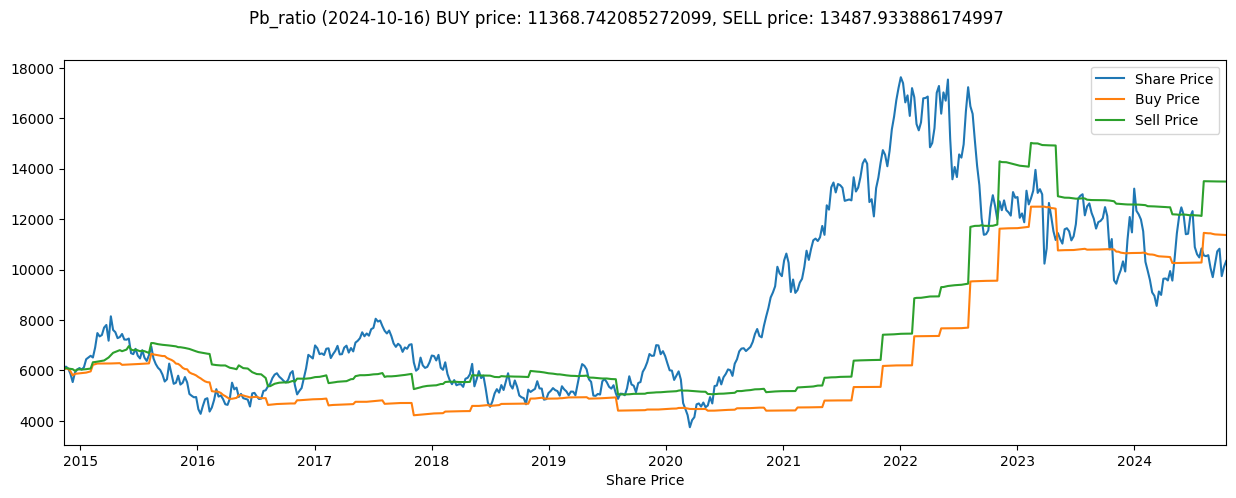

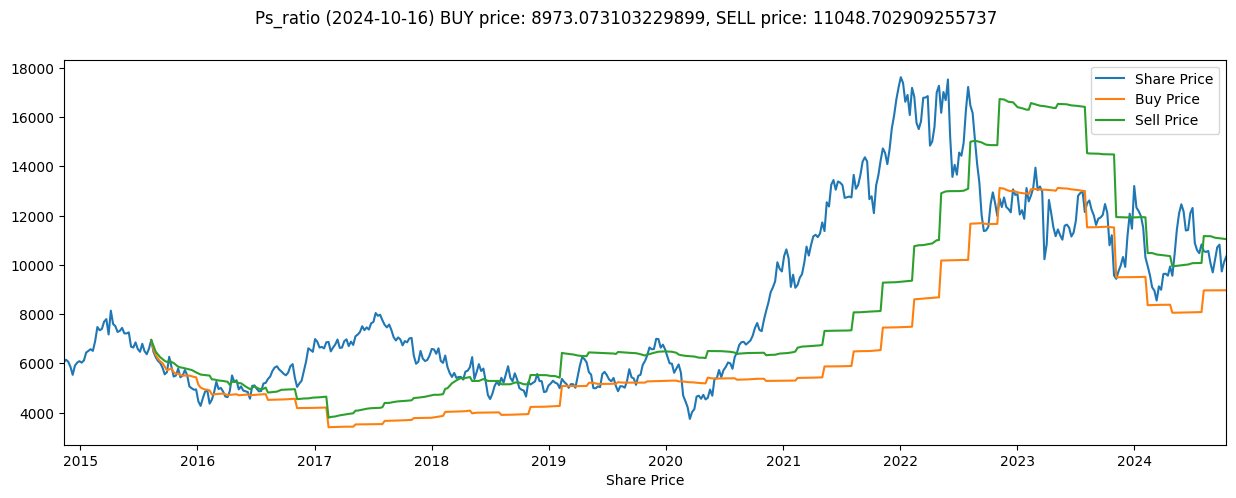

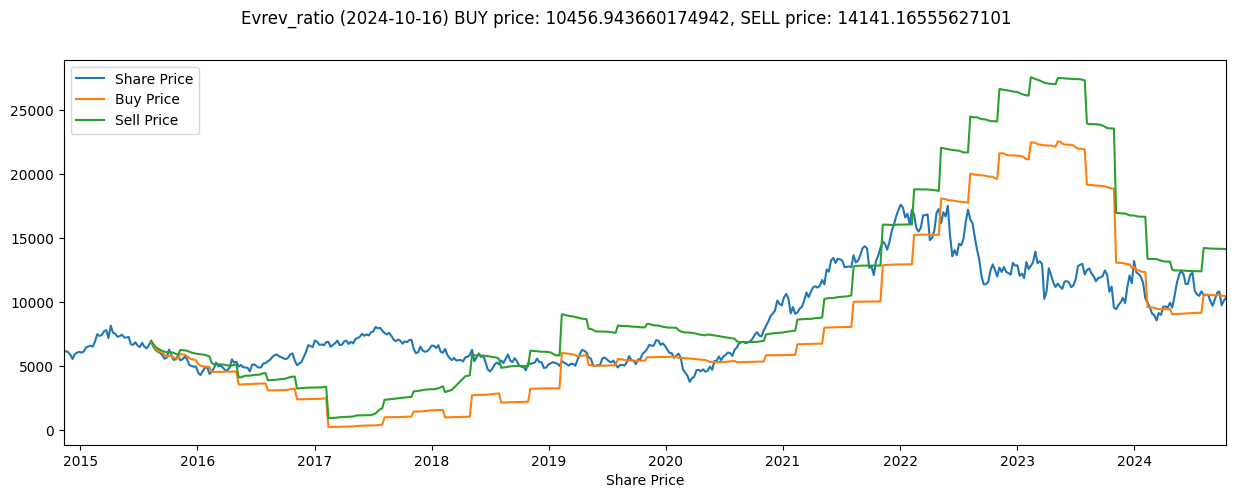

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)